# 7장 시계열 데이터를 다뤄보자
- 시계열 데이터란?
  - 일정 시간 간격으로 배치된 데이터들을 말함
  - 기록추세, 실시간 경고 또는 예측 모델링을 위해서 분석할 수 있음
  - 시계열 데이터의 예
    - 추세를 검색하기 위해 시간에 따라 캡쳐한 주가
    - 서버성능(예, CPU 사용량, I/O 부하, 메모리 사용량 및 네트워크 대역폭 사용량
    - 보류 중인 장비 오류 및 트리거 경고 알림을 검색하는데 사용할 수 있는 산업 장비 센서의 원격 분석
    - 주행에 대한 위험 점수 집계를 계산하기 위한 시간별 속도
    - 브레이크 사용 및 가속을 포함하는 실시간 자동차 원격 분석 데이터

In [ ]:
# Google Drive와 colab 연동

from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 7-1 Numpy의 polyfit으로 회귀 분석하기

In [34]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import numpy as np

from fbprophet import Prophet
from datetime import datetime

In [ ]:
# colab에서 한글 처리

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install font-nanum  # 리눅스 명령어

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarumGothic')
mpl.font_manager._rebuild

E: Unable to locate package font-nanum


<function matplotlib.font_manager._rebuild>

In [ ]:
# csv파일을 읽어오고 data, hit의 값들을 가져온다.
# index는 삭제
pinkwink_web = pd.read_csv('/content/gdrive/My Drive/data/07_PinkWink_Web_Traffic.csv',
                           encoding='utf-8', thousands=',', names = ['date','hit'], index_col=0)

# hit칼럼에 있는 값이 없는 경우 비워 놓지 않는다.
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
2019-04-01,766.0
2019-04-02,377.0
2019-04-03,427.0
2019-04-04,902.0
2019-04-05,850.0


findfont: Font family ['NanumBarumGothic'] not found. Falling back to DejaVu Sans.


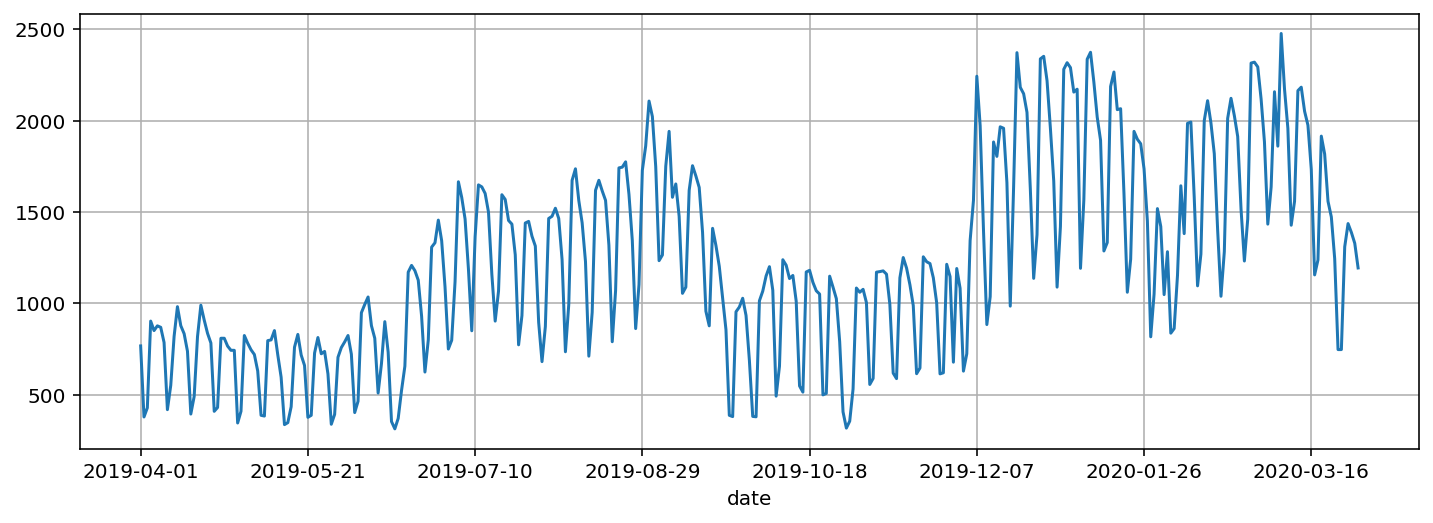

In [ ]:
# 그래프 출력
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

In [ ]:
# time 변수에 pinkwink_web에 있는 수만큼 넣어주고
time = np.arange(0,len(pinkwink_web))

# traffic에는 hit에 있는 값들을 넣어준다.
traffic = pinkwink_web['hit'].values

# 간격을 지정해 주고 범위를 1000으로 설정
fx = np.linspace(0, time[-1], 1000)

In [ ]:
# 여러 값을 계산하기 위한 함수 지정
# 모델의 적합성을 확인하는 과정으로 에러 함수 정의
# 참 값과 비교해서 에러를 계산

def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2))

In [ ]:
# 1장에서 한 것처럼 직선을 만들기 위해서 x, y축에 time, traffic 값을 넣어준다.
# polyfit() : 입력과 출력 값으로부터 다항식의 계수를 찾아주는 함수
# poly1d() : 1차항식

fp1 = np.polyfit(time, traffic, 1)  # 1차항
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)  # 2차항
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)  # 3차항
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15) # 15차항
f15 = np.poly1d(f15p)

# 위에서 만든 에러 값을 구하는 함수에 각각의 값을 넣어서 에러값을 구해 준다.
print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.8597308110963
430.6284101894695
429.53280466762925
330.47773021321143


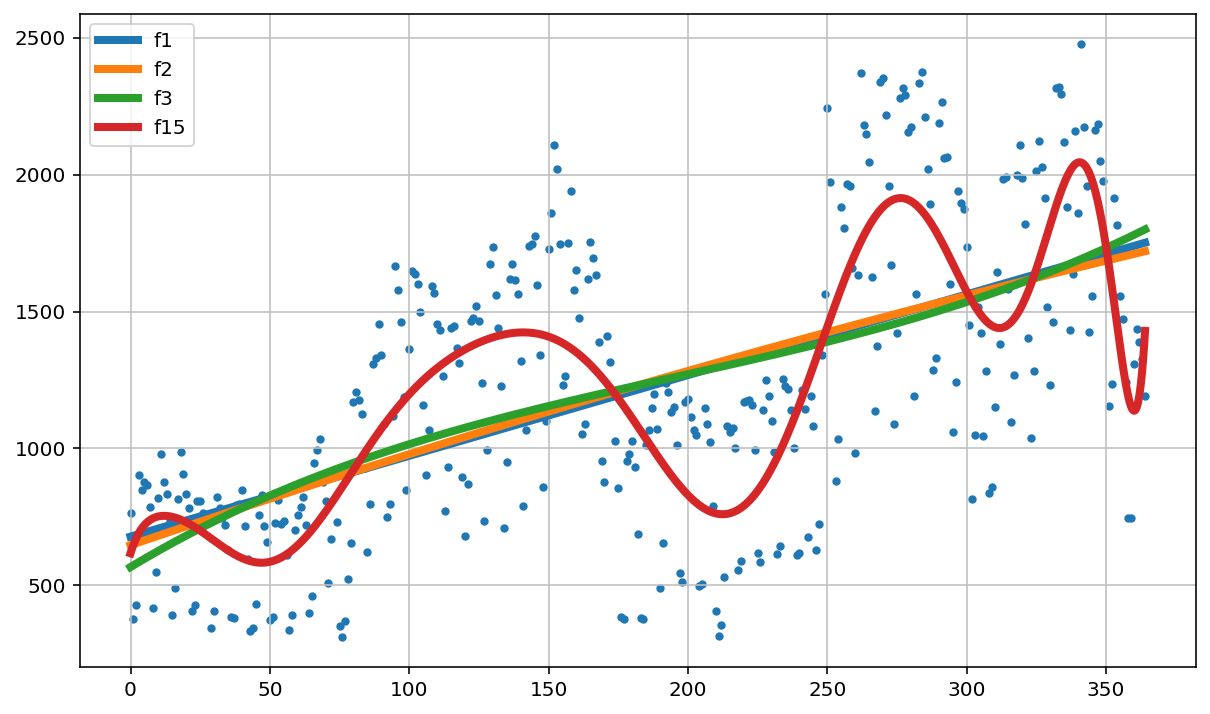

In [ ]:
# 그래프 사이즈를 지정해 주고 산포도 그래프를 그린다.
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

# 각각의 그래프마다의 값을 넣어주고 라벨값을 표시해 준다.
plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')

plt.legend(loc=2)  # 범례
plt.show()

# 1, 2, 3, 15차 함수로 그래프로 표현한 결과
# 1차, 2차, 3차가 정의된 함수 에러를 확인해 보니 큰 차이가 없다.
# 2차나 3차로 표현하려면 그냥 1차로 표현하는 것이 더 나아 보임.
# 그렇다고 15차 함수를 사용해서 표현하는 것은 과적합

### 7-2 Prophet 모듈을 이용한 forecast 예측

In [ ]:
! pip install prophet

     |████████████████████████████████| 92kB 2.6MB/s 
  Created wheel for prophet: filename=prophet-0.1.1.post1-cp36-none-any.whl size=13236 sha256=7b331a5be740d9adb5cc6260cff0a9c717ea59a2a50a7437fc56ed58a29de7ad
  Stored in directory: /root/.cache/pip/wheels/71/d7/4f/0ade9b5843362f84d39c21edbe6065032e388053c4ab0ab83e
Successfully built prophet


In [46]:
# Prophet 모듈은 사용법이 아주 간단합니다.
# pinkwink_web 변수에서 날짜(index)와 방문수(hit)만을 따로 저장

# 데이터프레임을 만들어서 x에는 pinkwink_web의 index(date)를 넣어주고
# y에는 hit 값을 넣어준다.

df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})

# 실제 데이터에도 적용
df.reset_index(inplace=True)

# datetime 함수를 사용하여 년/월/일로 표시
df['ds'] =  pd.to_datetime(df['ds'], format="%Y-%m-%d")
del df['date']

# prophet 함수를 사용할 때, 주기가 연도 단위로 있다고 알려준다.
m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(df);

In [48]:
# 60일 간의 데이터를 추출하기 위해서 make_future_dataframe 함수를 사용한다.
# 맨 끝 부분 데이터를 출력

future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2020-05-25
421,2020-05-26
422,2020-05-27
423,2020-05-28
424,2020-05-29


In [49]:
# 예측한 데이터를 forecast 변수에 저장하고 끝 부분 데이터 출력
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2020-05-25,906.276937,677.602386,1116.444303
421,2020-05-26,491.217582,265.639317,699.402705
422,2020-05-27,623.828752,423.773217,834.341757
423,2020-05-28,1176.537710,958.323431,1374.297123
424,2020-05-29,1212.503048,996.032811,1429.292644


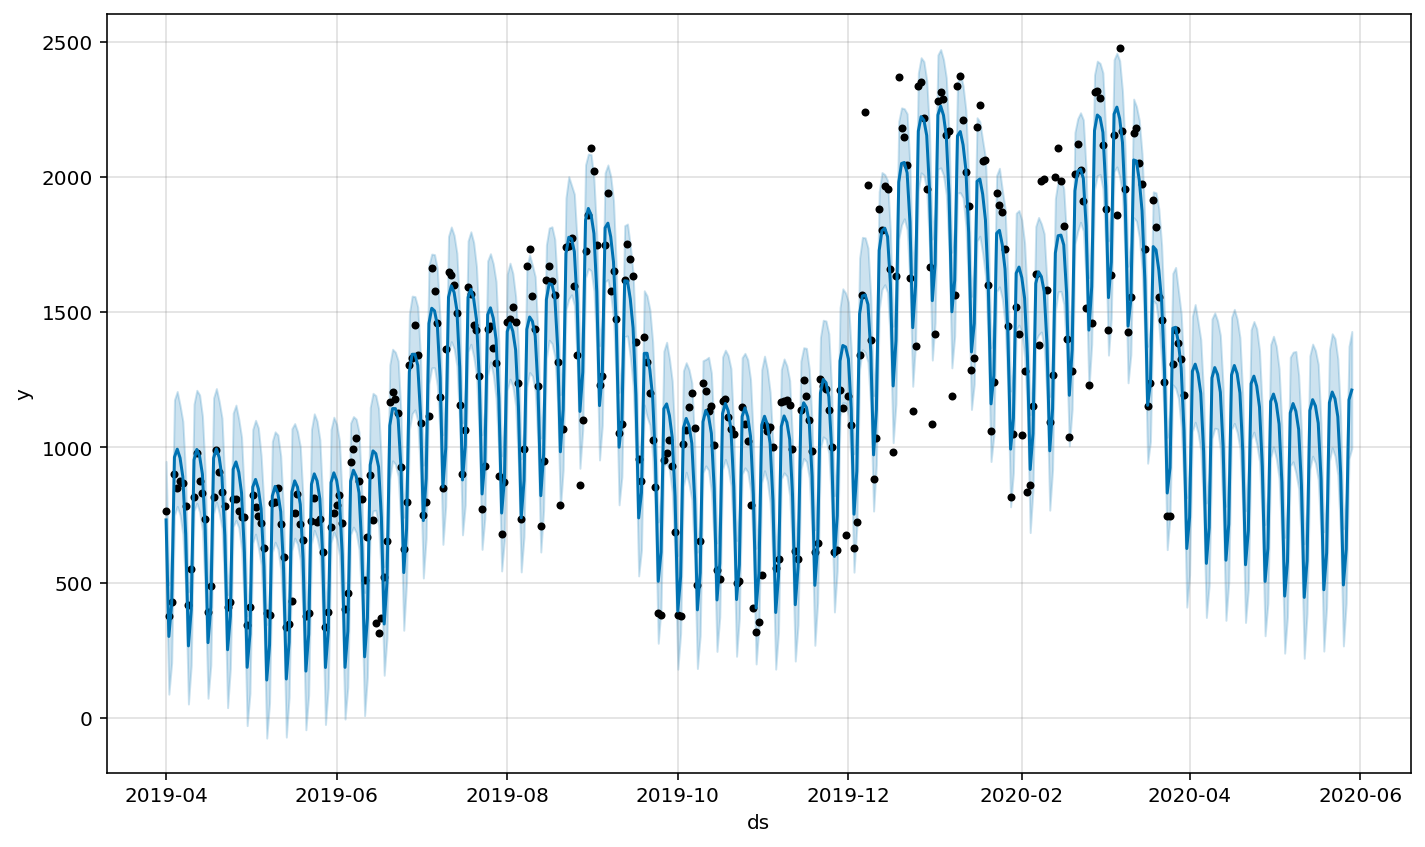

In [50]:
# 그래프 출력
m.plot(forecast);

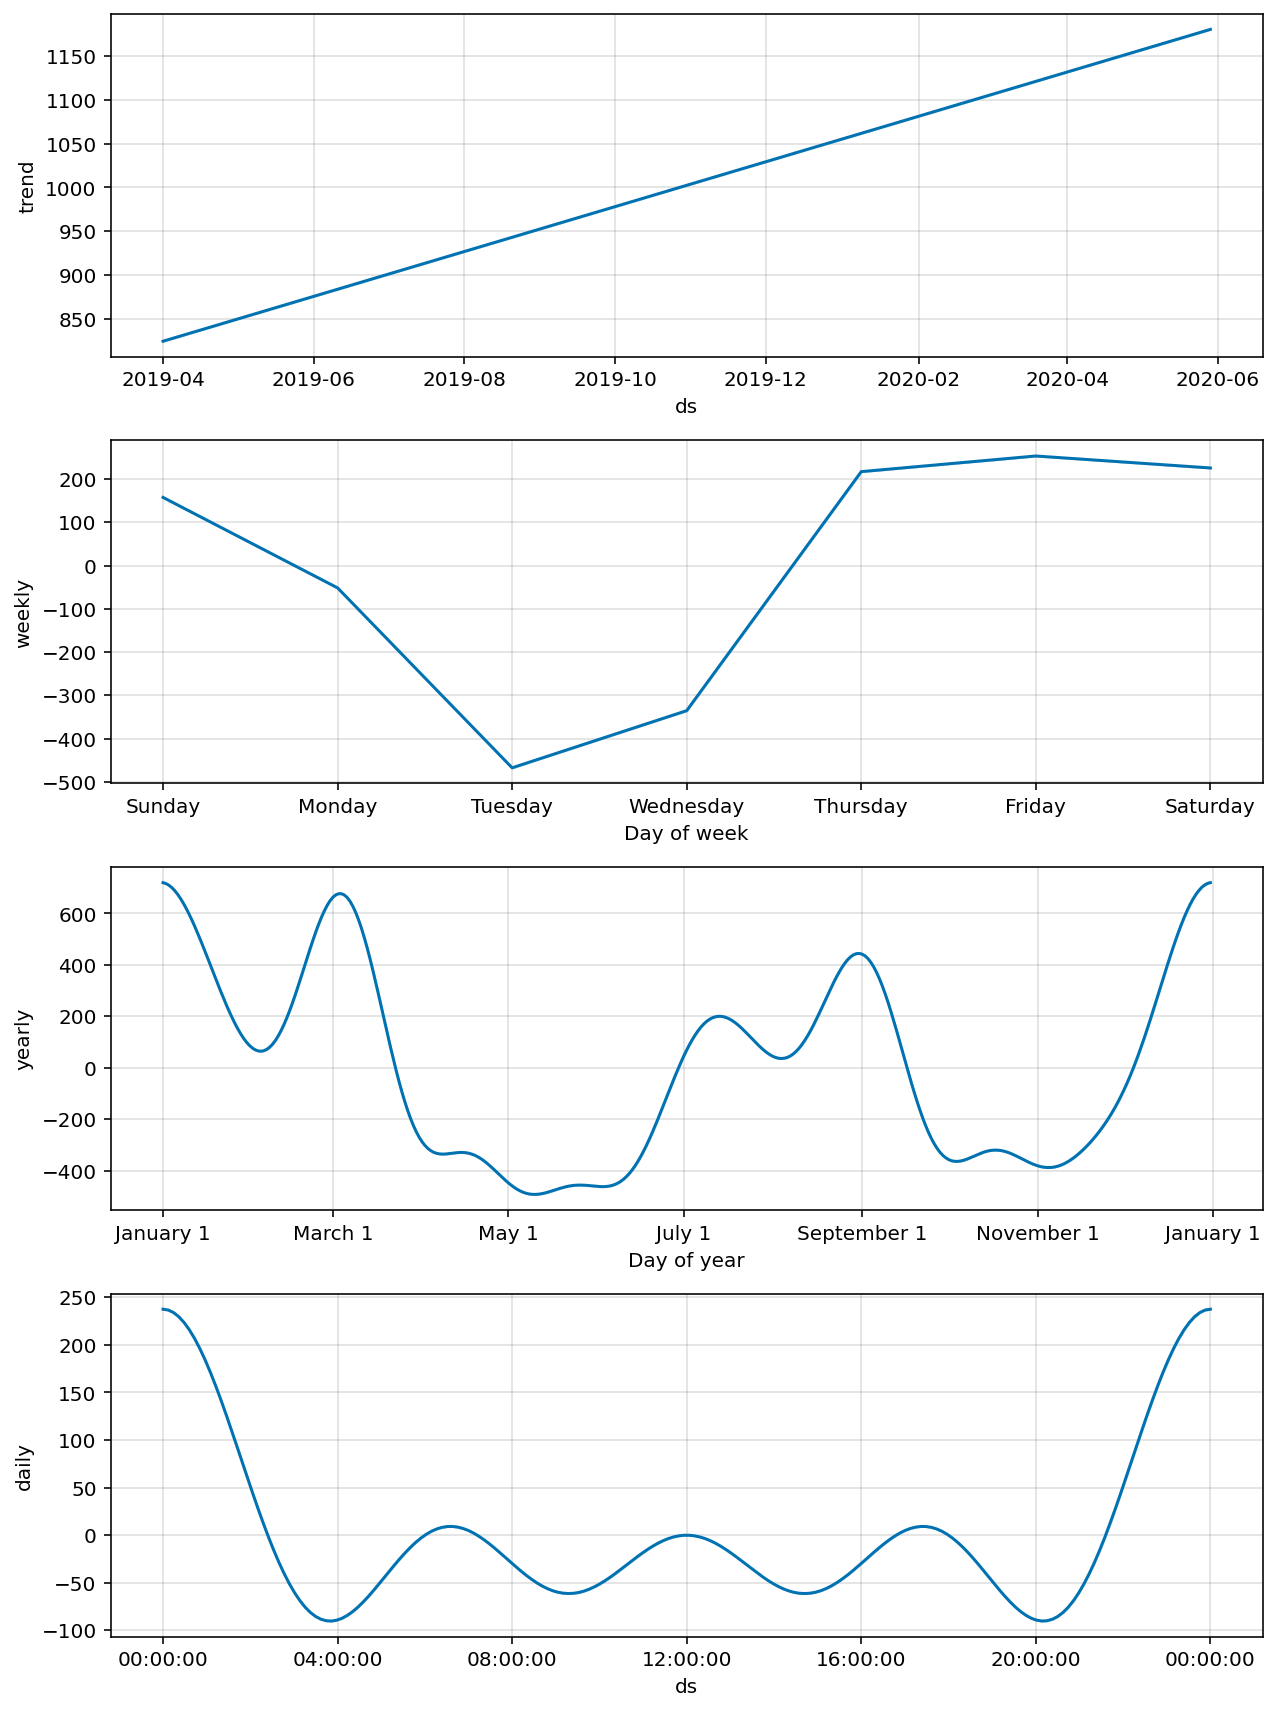

In [51]:
# components 함수로 forecast의 다양한 기준의 그래프를 출력한다.
m.plot_components(forecast);

### 7-3 Seasonal 시계열 분석으로 주석 데이터 분석하기

In [52]:
# 네이버 증권은 크롤링 거부, 증권사 API는 증권사 프로그램을 PC에 설치해야 해서
# 간편하게 Yahoo Finance의 데이터를 이용

!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=31a5b990bd96d4a77b24191420a25636d8789fa1d78e382b173984c34256dad6
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [53]:
!pip install pandas-datareader

In [54]:
# fix_yahoo_finance --> yfinance

import yfinance as yf
import pandas_datareader as pdr

In [56]:
# 시작일자, 끝일자를 지정한다.
start = datetime(2003, 1, 1)
end   = datetime(2017, 6, 30)

data = yf.download('AAPL', start, end)  # AAPL -> Apple Company

[*********************100%***********************]  1 of 1 completed


In [60]:
aapl = pd.DataFrame({"Date":data["Open"].index, "Open":data["Open"].values,
                    "High":data["High"].values, "Low":data["Low"].values,
                    "Close":data["Close"].values, "Volume":data["Volume"].values},
                    index = data["Open"].index)

aapl.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2003-01-02,2003-01-02,1.025714,1.065714,1.025000,1.057143,45357200
2003-01-03,2003-01-03,1.057143,1.066429,1.042143,1.064286,36863400
2003-01-06,2003-01-06,1.073571,1.098571,1.062857,1.064286,97633200
2003-01-07,2003-01-07,1.056429,1.071429,1.033571,1.060714,85586200
2003-01-08,2003-01-08,1.041429,1.050714,1.031429,1.039286,57411200


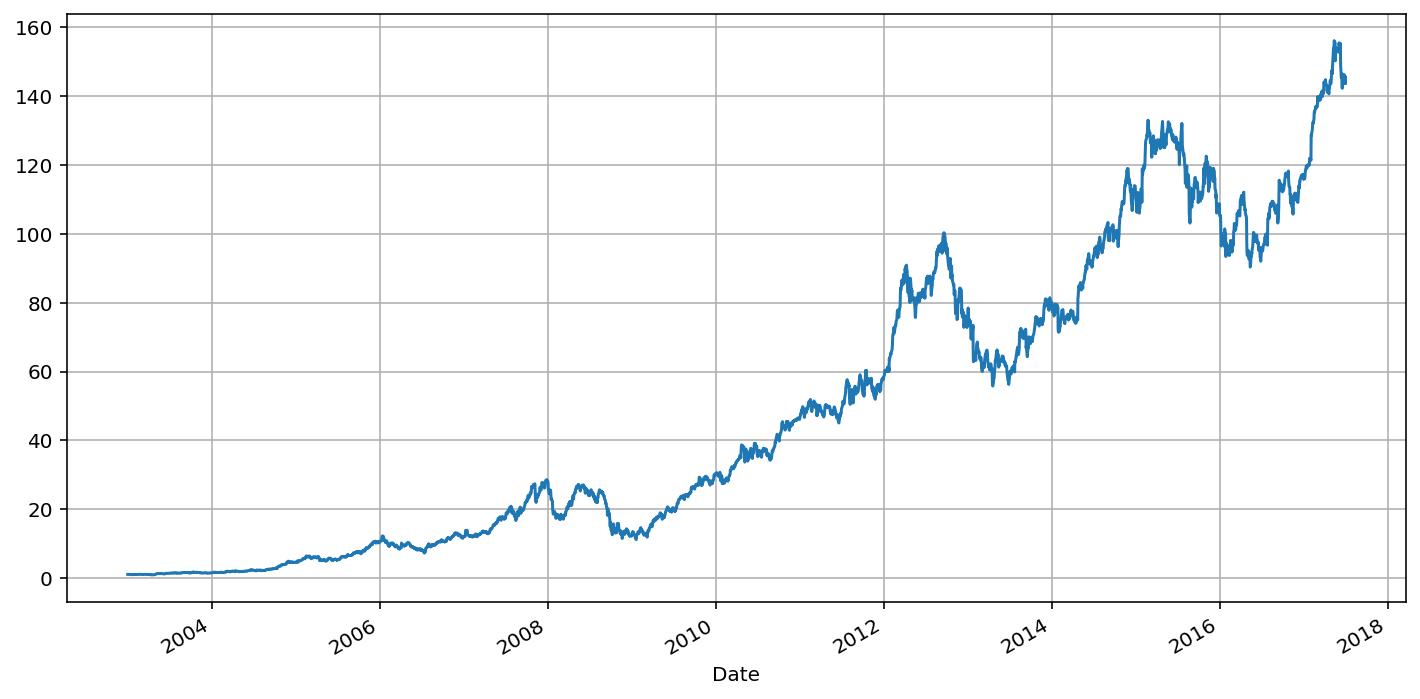

In [61]:
# Close 칼럼을 기준으로 그래프 출력
aapl['Close'].plot(figsize=(12,6), grid=True)

In [62]:
# 날짜를 사용하여 인덱싱
aapl_trunc = aapl[:'2017-06-30']
aapl_trunc.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2003-01-02,2003-01-02,1.025714,1.065714,1.025000,1.057143,45357200
2003-01-03,2003-01-03,1.057143,1.066429,1.042143,1.064286,36863400
2003-01-06,2003-01-06,1.073571,1.098571,1.062857,1.064286,97633200
2003-01-07,2003-01-07,1.056429,1.071429,1.033571,1.060714,85586200
2003-01-08,2003-01-08,1.041429,1.050714,1.031429,1.039286,57411200


In [63]:
# 데이터프레임의 x값을 aapl_trunc.index로, y값을 aapl_trunc['Close']로 넣어준다.
df = pd.DataFrame({'ds':aapl_trunc.index, 'y':aapl_trunc['Close']})

# 실제 데이터에도 적용
df.reset_index(inplace=True)
del df['Date']
df.head()

,ds,y
0,2003-01-02,1.057143
1,2003-01-03,1.064286
2,2003-01-06,1.064286
3,2003-01-07,1.060714
4,2003-01-08,1.039286


In [65]:
# df의 값을 예측한다.
# daily_seasonality --> 매일매일의 변화를 무시하고 예측

m = Prophet(daily_seasonality=True)
m.fit(df);  # fit() --> Prophet 객체는 1번만 fit할 수 있음

In [66]:
# df의 값을 1년 주기로 예측한다.
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4009,2018-06-25
4010,2018-06-26
4011,2018-06-27
4012,2018-06-28
4013,2018-06-29


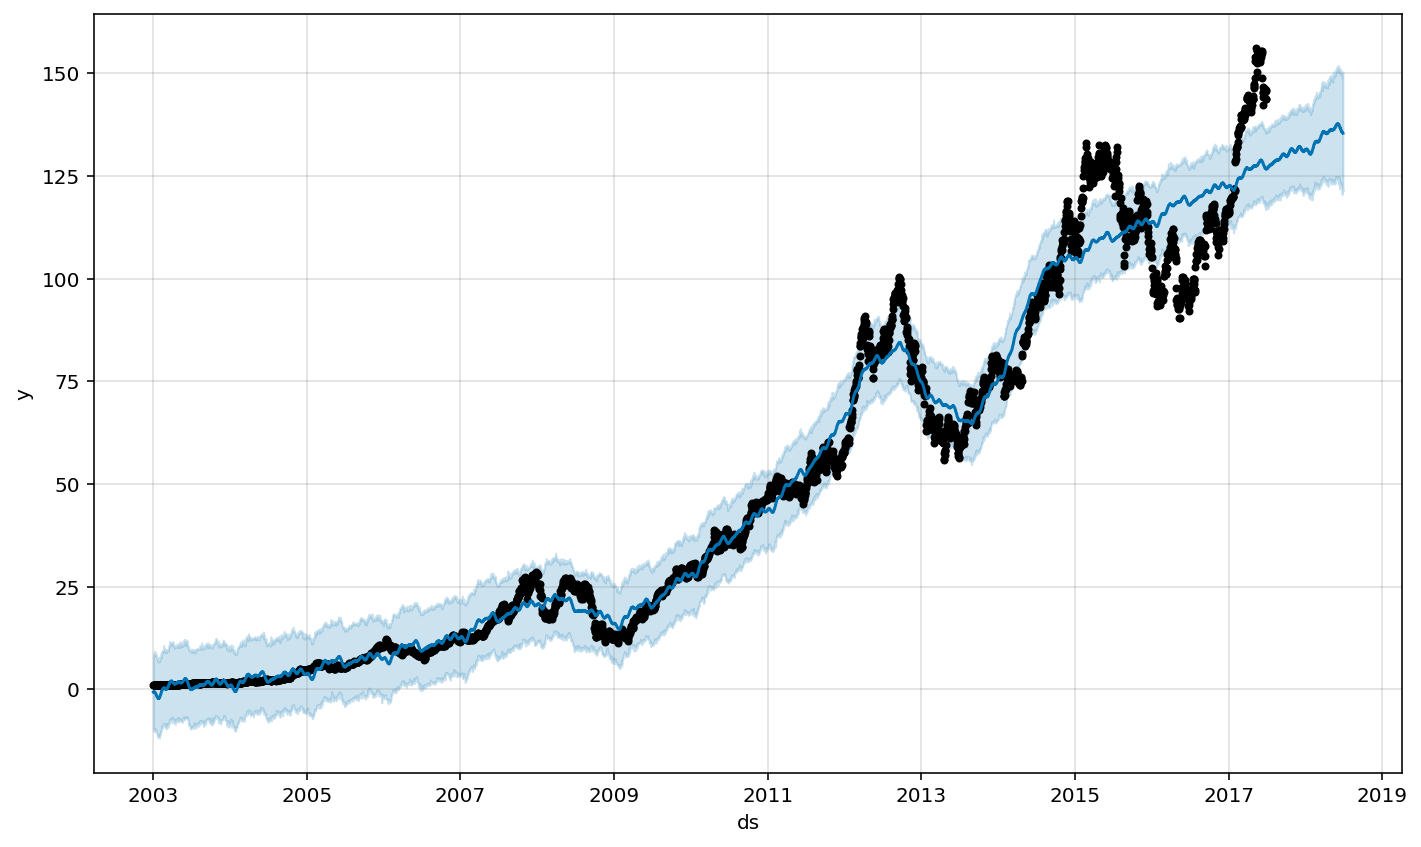

In [68]:
# 그래프 출력
forecast = m.predict(future)
m.plot(forecast);

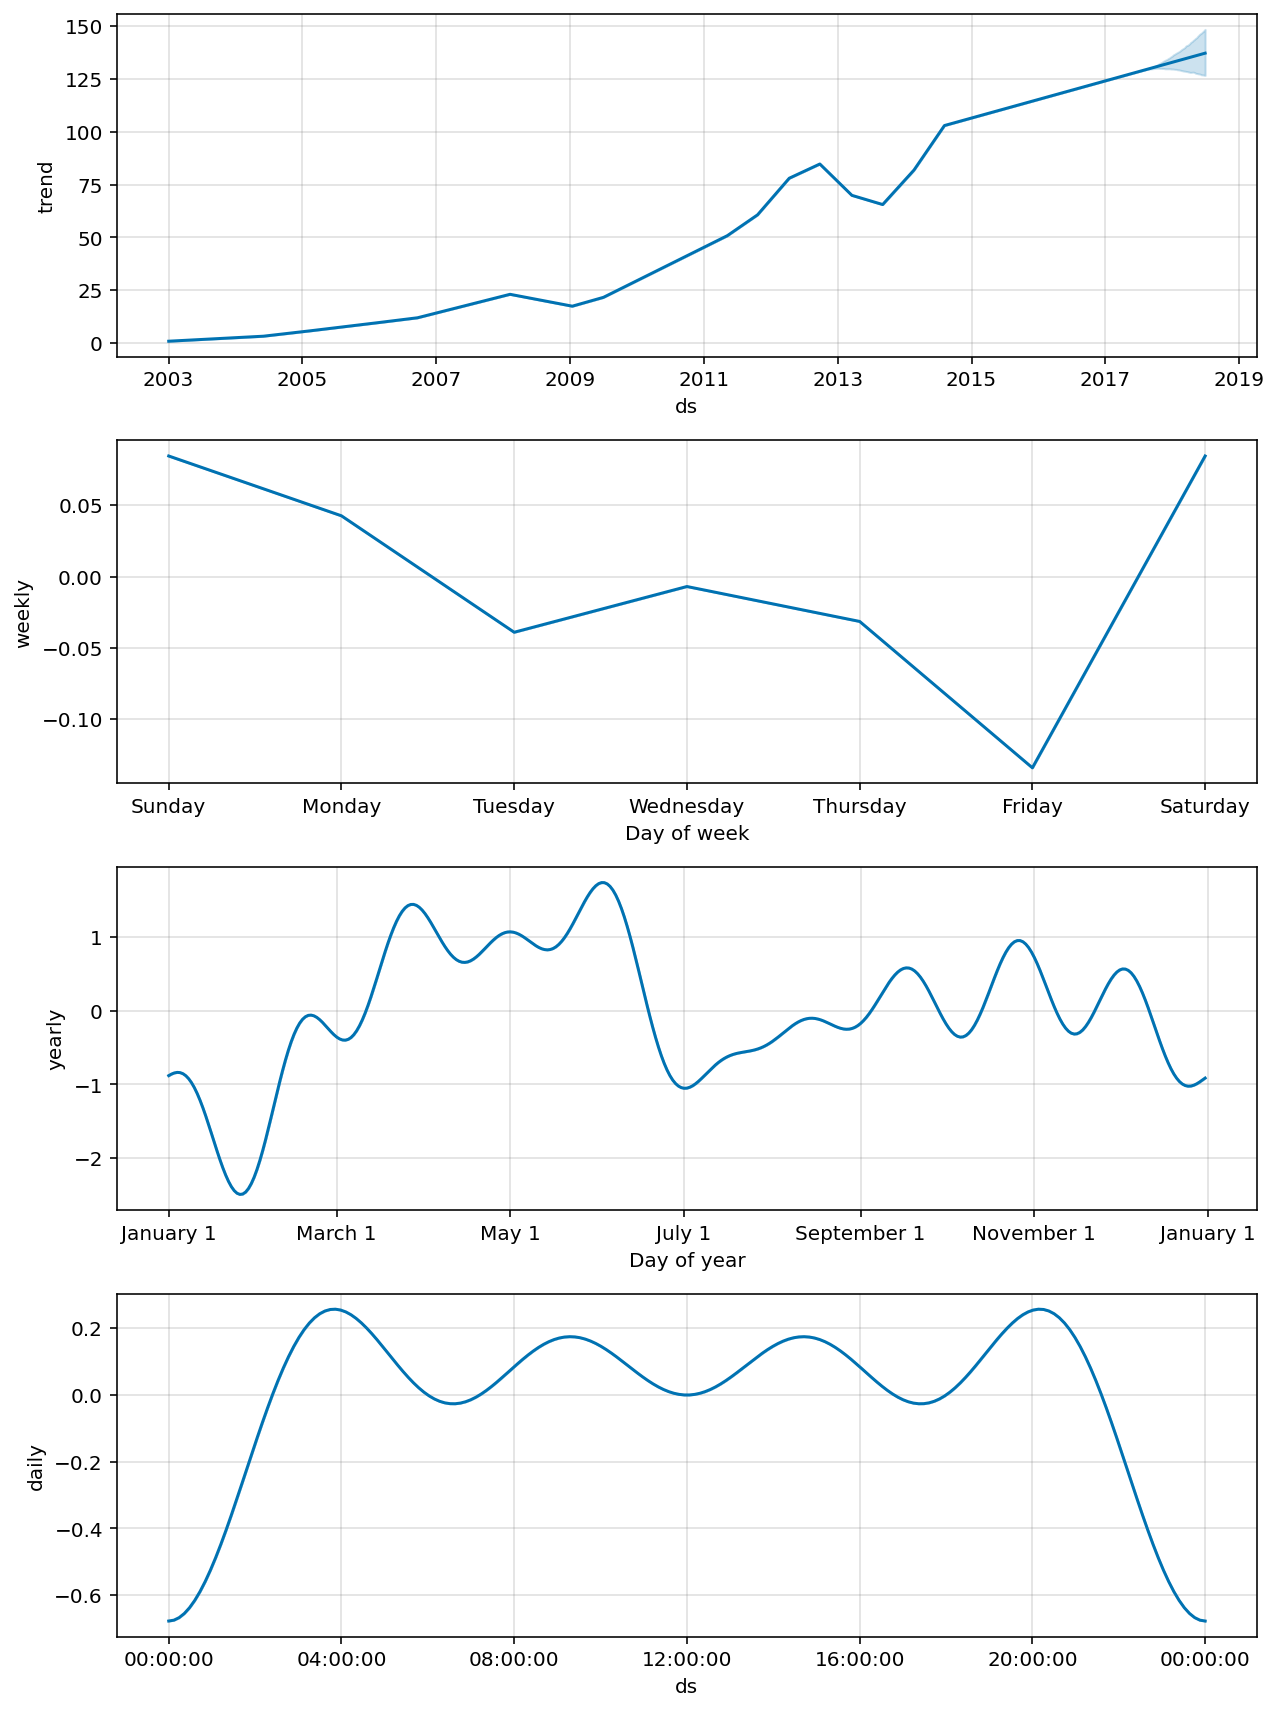

In [69]:
# 예측 그래프 출력
m.plot_components(forecast);

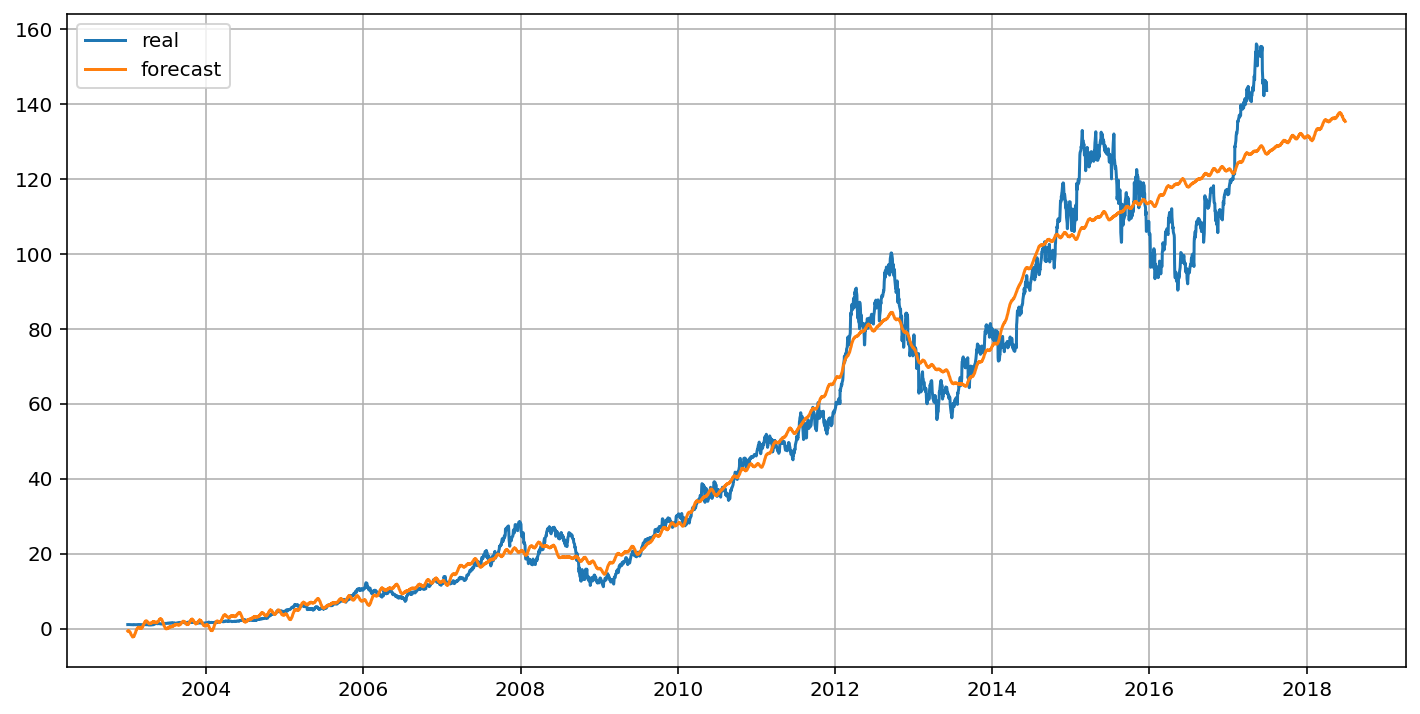

In [70]:
# 그래프 출력
plt.figure(figsize=(12,6))
plt.plot(aapl.index, aapl['Close'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

* pandas datareader를 이용하여 '삼성전자' 주식 데이터 가져오기

* get_code 항목에 '삼성전자' 대신에 다른 종목 입력해도 됨

In [74]:
import pandas as pd
import pandas_datareader as pdr

# 회사명으로 주식 종목 코드를 획득할 수 있도록 하는 함수
def get_code(df, name):
  code = df.query("name=='{}'".format(name))['code'].to_string(index=False)

  # 위와 같이 code명을 가져오면 앞에 공백이 붙어있는 상황이 발생하여
  # 앞뒤로 strip()하여 공백 제거
  code = code.strip()
  return code

# excel 파일을 다운로드 하는 것과 동시에 pandas에 load하기
# 흔히 사용하는 df라는 변수는 dataframe을 의미합니다.
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]

# data frame 정리
code_df = code_df[['회사명', '종목코드']]

# data frame title 변경 : '회사명' = 'name', '종목코드' = 'code'
code_df = code_df.rename(columns={'회사명' : 'name', '종목코드' : 'code'})

# 종목코드는 6자리로 구분되기 때문에 0을 채워 6자리로 변경
code_df.code = code_df.code.map('{:06d}'.format)

# ex) 삼성전자의 코드를 구해보겠습니다.
code = get_code(code_df, '삼성전자')

# yahoo의 주식 데이터 종목은 코스피는 .KS, 코스닥은 .KQ가 붙습니다.
# 삼성전자의 경우 코스피에 상장되어 있기 때문에 '종목코드.KS'로 처리하도록 한다.
code = code + '.KS'

# get_data_yahoo API를 통해서 yahoo finance의 주식 종목 데이터를 가져온다.
df = pdr.get_data_yahoo(code)

In [75]:
code

'005930.KS'

In [76]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-30,25200.0,24300.0,25160.0,24300.0,15419600.0,245.248688
2015-07-31,24440.0,23500.0,24400.0,23700.0,19579450.0,239.193115
2015-08-03,23680.0,23320.0,23680.0,23500.0,9844550.0,237.174606
2015-08-04,23740.0,23400.0,23500.0,23640.0,12844350.0,238.587570
2015-08-05,23640.0,23160.0,23640.0,23180.0,12802500.0,233.945023
...,...,...,...,...,...,...
2020-07-22,55500.0,54700.0,55300.0,54700.0,12885057.0,54700.000000
2020-07-23,54700.0,53800.0,54700.0,54100.0,16214932.0,54100.000000
2020-07-24,54400.0,53700.0,54000.0,54200.0,10994535.0,54200.000000


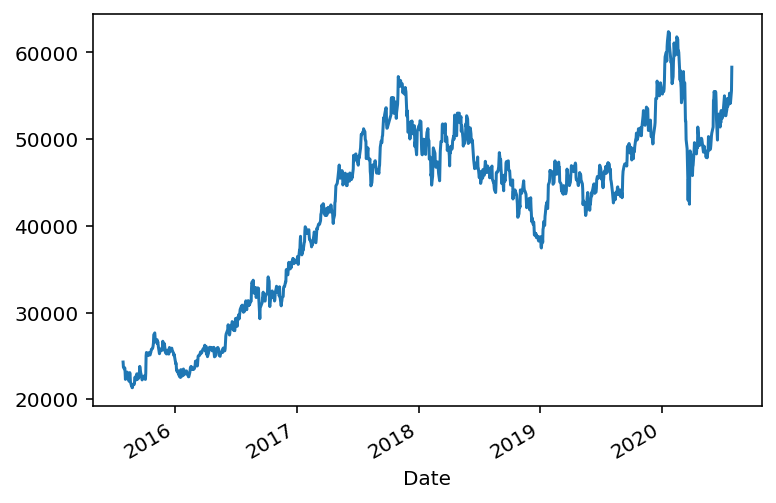

In [77]:
# 현재 data frame에서 Close(종가) 기준으로 그래프 생성
df['Close'].plot()

In [78]:
# 코스닥 종목인지 코스피 종목인지 판단이 안 되기 때문에
# 코스탁, 코스피 정보를 각각 획득하여 데이터를 가공한 후 다시 정렬

### 7-4 Growth Model과 Holiday Forecast
* prophet의 튜토리얼에서 나오는 예제

In [80]:
df = pd.read_csv('/content/gdrive/My Drive/data/07_example_wp_R.csv')

# y 칼럼의 값을 log로 계산해 준다.
df['y'] = np.log(df['y'])

In [85]:
df['cap'] = 8.5

In [86]:
m = Prophet(daily_seasonality=True, growth='logistic')
m.fit(df)

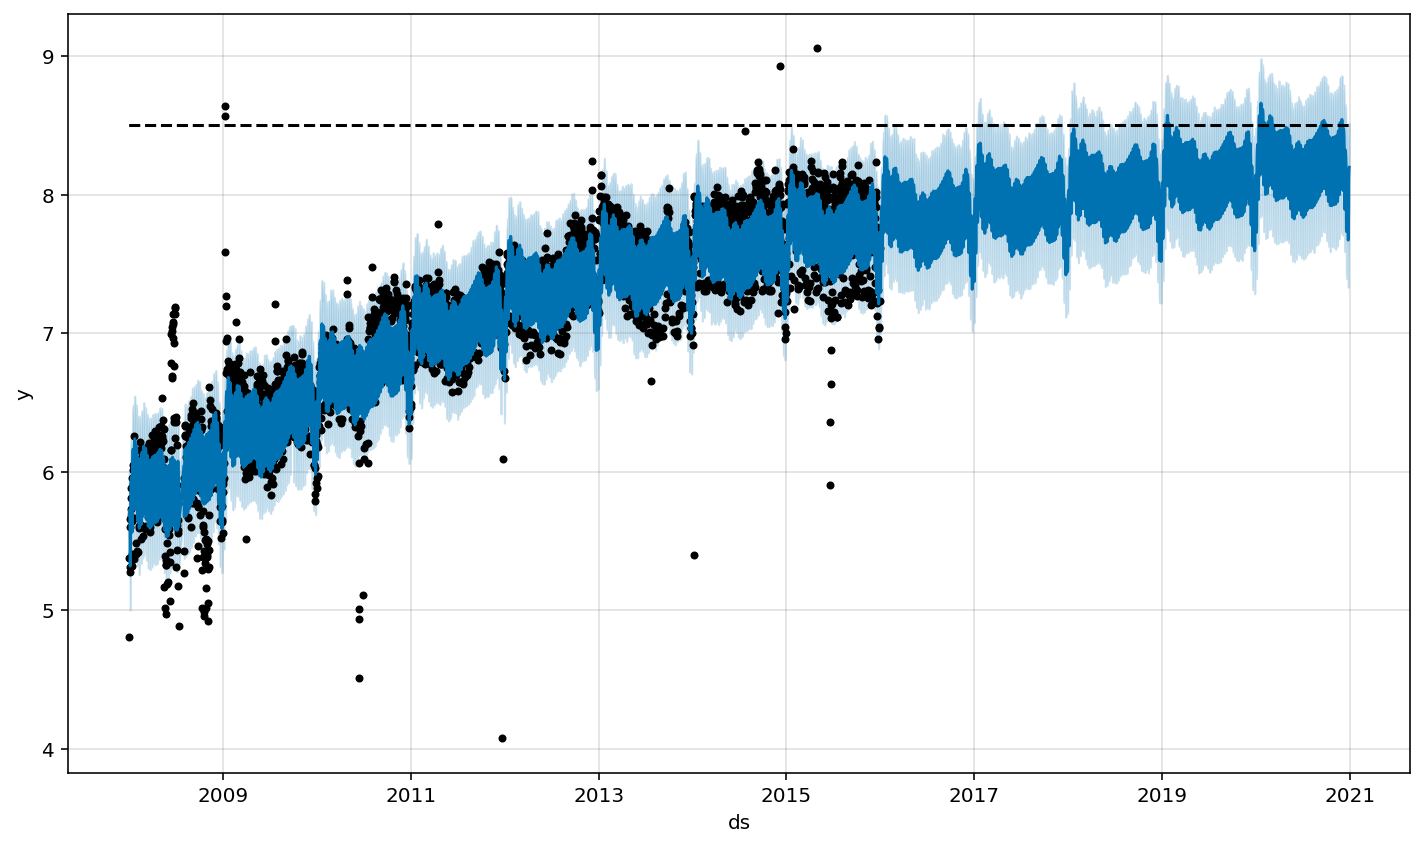

In [87]:
# 1826일 주기로 설정하고 예측한다.
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
m.plot(fcst);

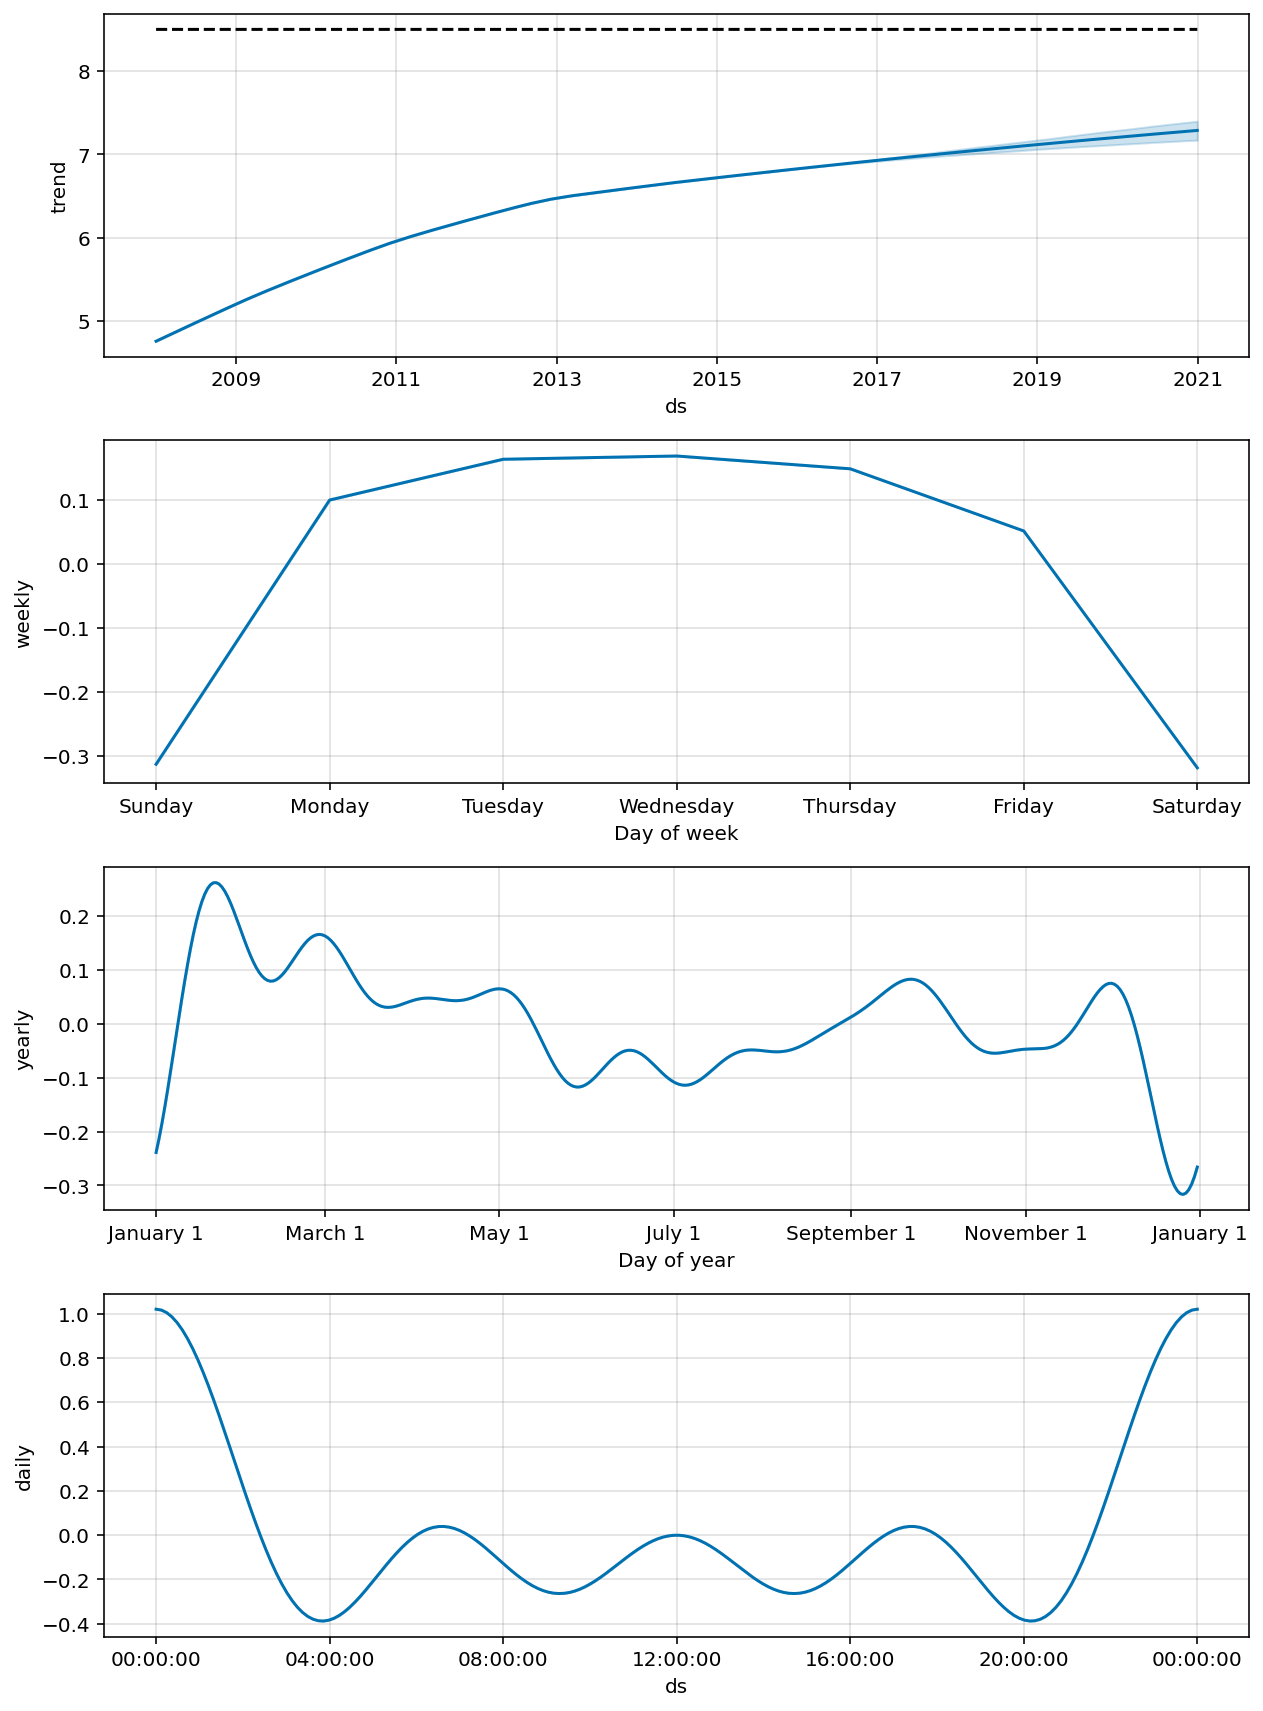

In [88]:
# 그래프 출력. 전체적인 trend, 주간 분석, 연간 분석의 결과를 그래프로 출력
forecast = m.predict(future)
m.plot_components(forecast);